# CS4035 - Cyber Data Analytics
## Lab1 - Fraud data

## Individual Part - Rank Swapping

## Group 1

### Name : Athanasios Georgoutsos
### ID : 6015883

### Word Counter

In [34]:
# If this cell does not work try running `pip install nbformat`

import io
# from IPython 
import nbformat

nb = nbformat.read("lab1_rank_swapping.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 299


## Libraries Required - Data Paths - General Instructions

In [1]:
# Libraries used in this lab assignment, in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

# NOTE: The following code defines the paths of the data files
# Modify with your own paths OR
# Create a directory with the name "cda-lab-1-credit-card-fraud" in the same directory 
# as this .ipynb file and place the data files in it

train_path = 'cda-lab-1-credit-card-fraud/train_data.csv'
test_path = 'cda-lab-1-credit-card-fraud/test_data.csv'

## 3. Privacy task – 1 A4 – Individual

### Data Preprocessing

In [2]:
# Basic data preprocessing - adapted, as given, from the W1_Visuals.ipynb notebook

# Data loading
df = pd.read_csv(train_path)

#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df['card_id'])
df['card_id'] = card_enc.transform(df.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df['ip_id'])
df['ip_id'] = ip_enc.transform(df.ip_id)

#Encoding, Cleaning the data
df.loc[df['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df.loc[df['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df.loc[df['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df['issuercountrycode'].unique()
unique_shopper_cc = df['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df['issuercountrycode'] = enc.transform(df.issuercountrycode)
df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)
df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df['txvariantcode'])
df['txvariantcode'] = enc1.transform(df.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df['currencycode'])
df['currencycode'] = enc2.transform(df.currencycode)

enc3 = LabelEncoder()
enc3.fit(df['shopperinteraction'])
df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
df['accountcode_cc'] = 0
df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df.loc[(df['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df.loc[(df['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df.loc[(df['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df['accountcode'])
df['accountcode'] = enc4.transform(df.accountcode)

### Better to use one-hot encoding, very few categories
enc5 = LabelEncoder()
enc5.fit(df['cardverificationcodesupplied'])
df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

df.loc[df['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df['mail_id'])
df['mail_id'] = enc6.transform(df.mail_id)

df.loc[df['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
df.loc[df['countries_equal'] == False,'countries_equal'] = 0
df.loc[df['countries_equal'] == True,'countries_equal'] = 1

C:\Users\Thanos\AppData\Local\Temp\ipykernel_11364\2934509475.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_11364\2934509475.py:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['countries_equal'] == False,'countries_equal'] = 0


In [3]:
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


In [4]:
# Additional Preprocessing

"""
1.  Combine the 'cardverificationcodesupplied' and 'cvcresponsecode' columns
    as these features are closely related. New column is  'cvc_outcome'.
    We combine the 'cvcresponsecode' Unknown (0) and Not checked (3)
    Values:
    1: 'cardverificationcodesupplied' = 0 and 'cvcresponsecode' = 0 or 3
    2: 'cardverificationcodesupplied' = 0 and 'cvcresponsecode' = 1
    3: 'cardverificationcodesupplied' = 0 and 'cvcresponsecode' = 2
    4: 'cardverificationcodesupplied' = 1 and 'cvcresponsecode' = 0 or 3
    5: 'cardverificationcodesupplied' = 1 and 'cvcresponsecode' = 1
    6: 'cardverificationcodesupplied' = 1 and 'cvcresponsecode' = 2
"""

df['cvc_outcome'] = 1
df.loc[((df['cardverificationcodesupplied'] == 0) & (df['cvcresponsecode'].isin([0, 3]))), 'cvc_outcome'] = 1
df.loc[((df['cardverificationcodesupplied'] == 0) & (df['cvcresponsecode'] == 1)), 'cvc_outcome'] = 2
df.loc[((df['cardverificationcodesupplied'] == 0) & (df['cvcresponsecode'] == 2)), 'cvc_outcome'] = 3
df.loc[((df['cardverificationcodesupplied'] == 1) & (df['cvcresponsecode'].isin([0, 3]))), 'cvc_outcome'] = 4
df.loc[((df['cardverificationcodesupplied'] == 1) & (df['cvcresponsecode'] == 1)), 'cvc_outcome'] = 5
df.loc[((df['cardverificationcodesupplied'] == 1) & (df['cvcresponsecode'] == 2)), 'cvc_outcome'] = 6

"""
2. Scale numeric features using StandardScaler
"""

scaler = MinMaxScaler()
df[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id']] = scaler.fit_transform(df[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id']])


In [5]:
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal,cvc_outcome
0,1,49,2,0.915256,0.002275,1,49,1,1,1,3,0.104575,0.074526,0.613989,0,0.014966,GB,1,5
1,2,49,3,0.985768,0.001710,1,49,1,1,1,3,0.679079,0.638575,0.173973,0,0.011269,GB,1,5
2,3,49,2,0.889650,0.001966,1,49,1,1,1,3,0.497187,0.518869,0.720433,0,0.012942,GB,1,5
3,4,49,8,0.412956,0.007821,1,49,0,0,0,3,0.586427,0.874296,0.085653,0,0.051252,GB,1,1
4,6,49,8,0.470509,0.002580,1,49,1,1,1,3,0.720216,0.335182,0.441547,0,0.016957,GB,1,5


In [6]:
# get features and labels
# keep only numeric features
X = df[['issuercountrycode','txvariantcode','bin', 'amount', 'currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','cvc_outcome','accountcode','mail_id','ip_id','card_id','amount_eur','countries_equal']]
y = df['label']

### Rank Swapping Implementation

In [7]:
# Function for rank swapping implementation
# Following the definition for rank swapping, as given in the paper "A SURVEY OF INFERENCE 
# CONTROL METHODS FOR PRIVACY-PRESERVING DATA MINING" by Josep Domingo-Ferrer

def rank_swapping(df, columns, p=0.1, method='average', two_way_swapping=True):
    """
    Perform rank swapping on the input dataframe
    
    Parameters:
    df: input dataframe
    columns: list of columns on which rank swapping is to be performed
    p:  maximum percentage difference between the original and swapped ranks
    method: method to be used for ranking, to break ties
    two_way_swapping: if True, swaps values for both indices (like the paper)
                     else if False, replaces only the value of the first index (like lecture slides)
                     NOTE: If False is selected, it could change the distribution of the values for this attribute
    
    Returns:
    df: dataframe with rank swapping performed
    """

    # copy dataframe
    final_df = df.copy()

    for c in columns:
        
        # step 1: get the values of the attribute-column
        values = final_df[c]
        
        # step 2: sort them in ascending order and get the ranks
        values = values.sort_values()
        ranks = values.rank(method=method)
        
        new_values = values.copy()
        indices = values.index.tolist()
        # list for already swapped indices
        swapped = [] 
        
        # step 3: perform the swapping
        
        if two_way_swapping:
            for i in indices:
                # if the value of this index is already swapped, continue
                if i in swapped:
                    continue

                swapped.append(i)

                # get the rank of the current value
                rank = ranks[i]
            
                # get the minimum and maximum rank that can be swapped with it
                min_rank = rank - p * len(values)
                max_rank = rank + p * len(values)

                # get the indices of the values that fall between the rank limits
                candidates = ranks[(ranks >= min_rank) & (ranks <= max_rank)].index.tolist()

                # keep only the ones not already swapped
                candidates = [c for c in candidates if c not in swapped]

                # if no candidates found, continue
                if len(candidates) == 0:
                    continue

                # get the index of the value to be swapped
                swap_index = np.random.choice(candidates)
                swapped.append(swap_index)
                
                # swap the values
                new_values[i], new_values[swap_index] = values[swap_index], values[i]
        else:
            for i in indices:

                # get the rank of the current value
                rank = ranks[i]
            
                # get the minimum and maximum rank that can be swapped with it
                min_rank = rank - p * len(values)
                max_rank = rank + p * len(values)

                # get the indices of the values that fall between the rank limits
                candidates = ranks[(ranks >= min_rank) & (ranks <= max_rank)].index.tolist()

                # get the index of the value to be swapped
                swap_index = np.random.choice(candidates)
                
                # swap the values
                new_values[i] = values[swap_index]

        # sort and replace with the new values
        values = new_values.sort_index()
        final_df[c] = values
        
    return final_df

### Split Data - Apply Rank Swapping

In [8]:
# rank swapping is performed (and makes sense) for features with multiple values if rank method='average', 
# since for features with a few values the rank differences are quite big not allowing any swapping

for col in X.columns:
    print(col, len(X[col].unique()))

issuercountrycode 112
txvariantcode 13
bin 2369
amount 8749
currencycode 5
shoppercountrycode 137
shopperinteraction 3
cardverificationcodesupplied 2
cvcresponsecode 4
cvc_outcome 5
accountcode 4
mail_id 170261
ip_id 168238
card_id 171763
amount_eur 10420
countries_equal 2


In [9]:
# For small values of parameter p and method='average', the columns with a few unique values
# would lead to rank differences that are too big, not allowing any swapping
# However, for this exercise, we are going to use all columns, since we are going to explore different
# values for parameter p

swap_columns = X.columns

In [10]:
# Split the data into train and test set (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform under-sampling of the majority class for the train set
# This is done to balance the dataset and because other methods are too computationally expensive
# for performing rank swapping
print("Train dataset shape before under-sampling:", sorted(Counter(y_train).items()))
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)
print("New train dataset shape after under-sampling:", sorted(Counter(y_resampled).items()))

X_train, y_train = X_resampled, y_resampled


Train dataset shape before under-sampling: [(0, 151490), (1, 212)]
New train dataset shape after under-sampling: [(0, 212), (1, 212)]


In [11]:
# Apply rank swapping on the training data
# Use swap_columns defined earlier

# Since we limited the train data, we can explore different p parameters for rank swapping
# Larger p value means greater privacy, but we are expecting worse classification performance
p_values = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0]
X_train_swapped = []
for p in p_values:
    X_train_swapped.append(rank_swapping(X_train, swap_columns, p=p, method='average', two_way_swapping=True))
    print(f"Rank swapping done for p={p}")

Rank swapping done for p=0.05
Rank swapping done for p=0.1
Rank swapping done for p=0.15
Rank swapping done for p=0.2
Rank swapping done for p=0.3
Rank swapping done for p=0.4
Rank swapping done for p=0.5
Rank swapping done for p=0.75
Rank swapping done for p=1.0


### Classifiers

##### Random Forest

In [12]:
rf_classifiers = []

# Use Random Forest Classifier on data without rank swapping

# Create a classifier
random_forest_original = RandomForestClassifier(random_state=42)

# Train the classifier on the train data without rank swapping
random_forest_original.fit(X_train, y_train)
rf_classifiers.append(random_forest_original)

# Predict on the test data
y_pred1_original = random_forest_original.predict(X_test)

# Calculate accuracy
acc1_original = accuracy_score(y_test, y_pred1_original)
print(f"Test accuracy: {acc1_original:.5f}")

Test accuracy: 0.88657


In [13]:
# Use Random Forest Classifier on data after rank swapping

y_pred1_swapped = []
acc1_swapped = []

for i in range(len(p_values)):
    # Create a classifier
    random_forest_swapped = RandomForestClassifier(random_state=42)

    # Train the classifier on the train data without rank swapping
    random_forest_swapped.fit(X_train_swapped[i], y_train)
    rf_classifiers.append(random_forest_swapped)

    # Predict on the test data
    y_pred1_swapped.append(random_forest_swapped.predict(X_test))
    
    # Calculate accuracy
    acc1_swapped.append(accuracy_score(y_test, y_pred1_swapped[i]))
    print(f"P-value: {p_values[i]:.2f} - Test accuracy: {acc1_swapped[i]:.5f}")

P-value: 0.05 - Test accuracy: 0.88383
P-value: 0.10 - Test accuracy: 0.87418
P-value: 0.15 - Test accuracy: 0.87344
P-value: 0.20 - Test accuracy: 0.85886
P-value: 0.30 - Test accuracy: 0.85379
P-value: 0.40 - Test accuracy: 0.81928
P-value: 0.50 - Test accuracy: 0.78666
P-value: 0.75 - Test accuracy: 0.61132
P-value: 1.00 - Test accuracy: 0.56294


##### SVM

In [14]:
svm_classifiers = []

# Use Support vector Machine on data without rank swapping

# Create a classifier
svm_original = SVC(probability=True, random_state=42)

# Train the classifier on the train data without rank swapping
svm_original.fit(X_train, y_train)
svm_classifiers.append(svm_original)

# Predict on the test data
y_pred2_original = svm_original.predict(X_test)

# Calculate accuracy
acc2_original = accuracy_score(y_test, y_pred2_original)
print(f"Test accuracy: {acc2_original:.5f}")

Test accuracy: 0.75305


In [15]:
# Use Support vector Machine on data after rank swapping
y_pred2_swapped = []
acc2_swapped = []

for i in range(len(p_values)):
    # Create a classifier
    svm_swapped = SVC(probability=True, random_state=42)

    # Train the classifier on the train data without rank swapping
    svm_swapped.fit(X_train_swapped[i], y_train)
    svm_classifiers.append(svm_swapped)

    # Predict on the test data
    y_pred2_swapped.append(svm_swapped.predict(X_test))

    # Calculate accuracy
    acc2_swapped.append(accuracy_score(y_test, y_pred2_swapped[i]))
    print(f"P-value: {p_values[i]:.2f} - Test accuracy: {acc2_swapped[i]:.5f}")

P-value: 0.05 - Test accuracy: 0.75286
P-value: 0.10 - Test accuracy: 0.75088
P-value: 0.15 - Test accuracy: 0.75207
P-value: 0.20 - Test accuracy: 0.75215
P-value: 0.30 - Test accuracy: 0.75310
P-value: 0.40 - Test accuracy: 0.10555
P-value: 0.50 - Test accuracy: 0.10217
P-value: 0.75 - Test accuracy: 0.24453
P-value: 1.00 - Test accuracy: 0.91766


##### MLP

In [16]:
mlp_classifiers = []

# Use Multi-Layer Perceptron on data without rank swapping

# Create a classifier
mlp_original = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(16, 8, 4), random_state=42)

# Train the classifier on the train data without rank swapping
mlp_original.fit(X_train, y_train)
mlp_classifiers.append(mlp_original)

# Predict on the test data
y_pred3_original = mlp_original.predict(X_test)

# Calculate accuracy
acc3_original = accuracy_score(y_test, y_pred3_original)
print(f"Test accuracy: {acc3_original:.5f}")

Test accuracy: 0.76341


c:\Users\Thanos\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
# Use Multi-Layer Perceptron on data after rank swapping
y_pred3_swapped = []
acc3_swapped = []

for i in range(len(p_values)):
    # Create a classifier
    mlp_swapped = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(16, 8, 4), random_state=42)

    # Train the classifier on the train data without rank swapping
    mlp_swapped.fit(X_train_swapped[i], y_train)
    mlp_classifiers.append(mlp_swapped)

    # Predict on the test data
    y_pred3_swapped.append(mlp_swapped.predict(X_test))

    # Calculate accuracy
    acc3_swapped.append(accuracy_score(y_test, y_pred3_swapped[i]))
    print(f"P-value: {p_values[i]:.2f} - Test accuracy: {acc3_swapped[i]:.5f}")

c:\Users\Thanos\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


P-value: 0.05 - Test accuracy: 0.77208


c:\Users\Thanos\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


P-value: 0.10 - Test accuracy: 0.73340


c:\Users\Thanos\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


P-value: 0.15 - Test accuracy: 0.73206


c:\Users\Thanos\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


P-value: 0.20 - Test accuracy: 0.74144


c:\Users\Thanos\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


P-value: 0.30 - Test accuracy: 0.72655


c:\Users\Thanos\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


P-value: 0.40 - Test accuracy: 0.02953
P-value: 0.50 - Test accuracy: 0.00525
P-value: 0.75 - Test accuracy: 0.00435
P-value: 1.00 - Test accuracy: 0.00796


##### Logistic Regression

In [19]:
lr_classifiers = []

# Use Logistic Regression on data without rank swapping

# Create a classifier
lr_original = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier on the train data without rank swapping
lr_original.fit(X_train, y_train)
lr_classifiers.append(lr_original)

# Predict on the test data
y_pred4_original = lr_original.predict(X_test)

# Calculate accuracy
acc4_original = accuracy_score(y_test, y_pred4_original)
print(f"Test accuracy: {acc4_original:.5f}")

Test accuracy: 0.81169


In [20]:
# Use Logistic Regression on data after rank swapping
y_pred4_swapped = []
acc4_swapped = []

for i in range(len(p_values)):
    # Create a classifier
    lr_swapped = LogisticRegression(max_iter=1000, random_state=42)

    # Train the classifier on the train data without rank swapping
    lr_swapped.fit(X_train_swapped[i], y_train)
    lr_classifiers.append(lr_swapped)

    # Predict on the test data
    y_pred4_swapped.append(lr_swapped.predict(X_test))

    # Calculate accuracy
    acc4_swapped.append(accuracy_score(y_test, y_pred4_swapped[i]))
    print(f"P-value: {p_values[i]:.2f} - Test accuracy: {acc4_swapped[i]:.5f}")

P-value: 0.05 - Test accuracy: 0.81206
P-value: 0.10 - Test accuracy: 0.81364
P-value: 0.15 - Test accuracy: 0.80910
P-value: 0.20 - Test accuracy: 0.81322
P-value: 0.30 - Test accuracy: 0.81416
P-value: 0.40 - Test accuracy: 0.81435
P-value: 0.50 - Test accuracy: 0.77947
P-value: 0.75 - Test accuracy: 0.68225
P-value: 1.00 - Test accuracy: 0.52022


##### Gradient Boosting

In [21]:
gb_classifiers = []

# Use Gradient Boosting on data without rank swapping

# Create a classifier
gb_original = GradientBoostingClassifier(random_state=42)

# Train the classifier on the train data without rank swapping
gb_original.fit(X_train, y_train)
gb_classifiers.append(gb_original)

# Predict on the test data
y_pred5_original = gb_original.predict(X_test)

# Calculate accuracy
acc5_original = accuracy_score(y_test, y_pred5_original)
print(f"Test accuracy: {acc5_original:.5f}")

Test accuracy: 0.87225


In [22]:
# Use Gradient Boosting on data after rank swapping
y_pred5_swapped = []
acc5_swapped = []

for i in range(len(p_values)):
    # Create a classifier
    gb_swapped = GradientBoostingClassifier(random_state=42)

    # Train the classifier on the train data without rank swapping
    gb_swapped.fit(X_train_swapped[i], y_train)
    gb_classifiers.append(gb_swapped)

    # Predict on the test data
    y_pred5_swapped.append(gb_swapped.predict(X_test))

    # Calculate accuracy
    acc5_swapped.append(accuracy_score(y_test, y_pred5_swapped[i]))
    print(f"P-value: {p_values[i]:.2f} - Test accuracy: {acc5_swapped[i]:.5f}")

P-value: 0.05 - Test accuracy: 0.87847
P-value: 0.10 - Test accuracy: 0.86711
P-value: 0.15 - Test accuracy: 0.87665
P-value: 0.20 - Test accuracy: 0.86656
P-value: 0.30 - Test accuracy: 0.85058
P-value: 0.40 - Test accuracy: 0.82619
P-value: 0.50 - Test accuracy: 0.77733
P-value: 0.75 - Test accuracy: 0.49333
P-value: 1.00 - Test accuracy: 0.50825


### 3a. Print ROC curves

In [23]:
def plot_roc_curve(original_classifier, swapped_classifier_list, X_test, y_test, p_value_list, title):
    """
    Plot the ROC curve for the given test labels and predicted labels
    
    Parameters:
    original_classifier: classifier on the original data
    swapped_classifier_list: list of classifiers on the data with rank swapping
    X_test: test data
    y_test: test labels
    p_value_list: list of p values used for rank swapping
    title: title of the plot
    """
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))

    # Start with the classifier on the original train data
    # Get the probabilities of the positive class - fraudulent transactions
    y_probs = original_classifier.predict_proba(X_test)[:, 1]

    # Compute the ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Original data, AUC = {auc_score:.2f}')

    # Continue with the classifiers on the swapped data
    for i in range(len(swapped_classifier_list)):

        # get classifier
        classifier = swapped_classifier_list[i]

        y_probs = classifier.predict_proba(X_test)[:, 1] 

        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Swapped data with p={p_value_list[i]}, AUC = {auc_score:.2f}')

    # plotting details
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

##### ROC curves

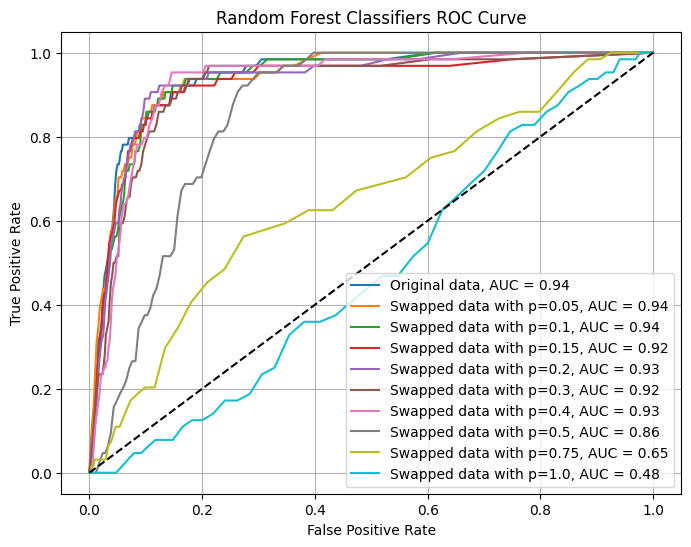

In [25]:
# Random Forest Classifiers ROC Curve
plot_roc_curve(rf_classifiers[0], rf_classifiers[1:], X_test, y_test, p_values, "Random Forest Classifiers ROC Curve")

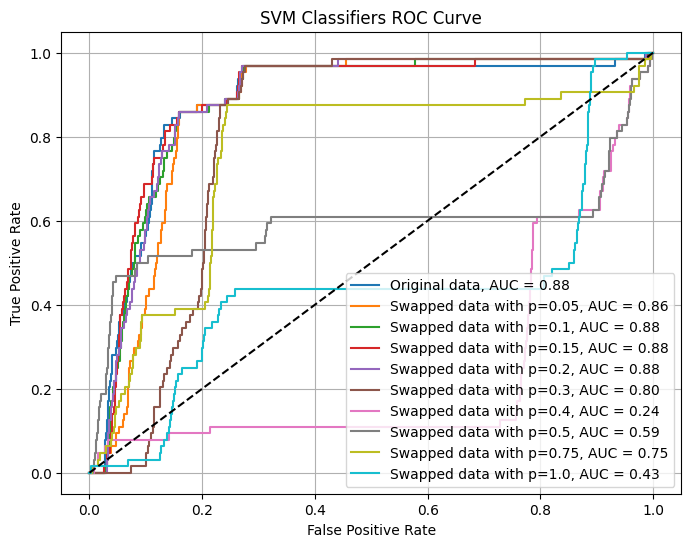

In [26]:
# Support Vector Machine Classifiers ROC Curve
plot_roc_curve(svm_classifiers[0], svm_classifiers[1:], X_test, y_test, p_values, "SVM Classifiers ROC Curve")

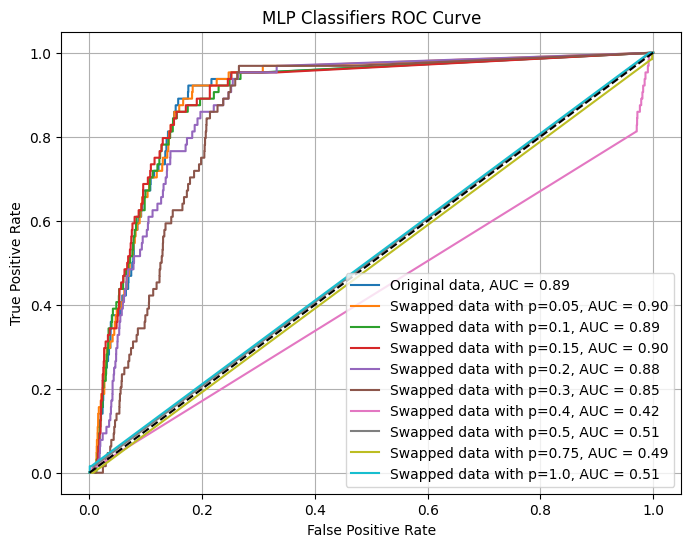

In [27]:
# Multi-Layer Perceptron Classifiers ROC Curve
plot_roc_curve(mlp_classifiers[0], mlp_classifiers[1:], X_test, y_test, p_values, "MLP Classifiers ROC Curve")

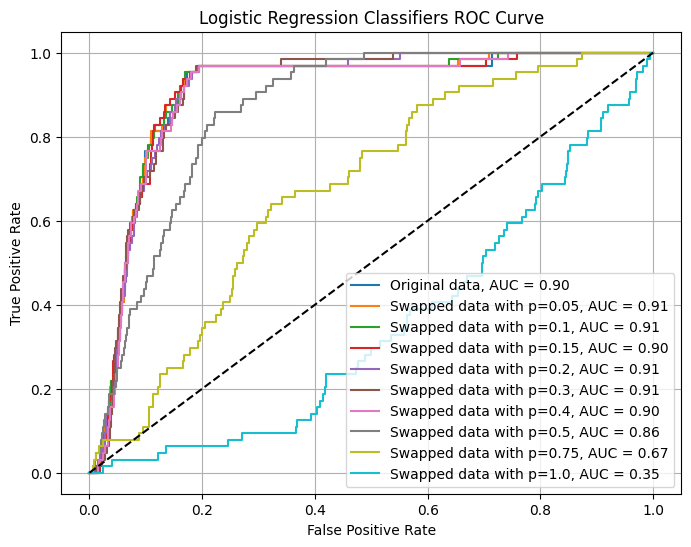

In [28]:
# Logisitc Regression Classifiers ROC Curve
plot_roc_curve(lr_classifiers[0], lr_classifiers[1:], X_test, y_test, p_values, "Logistic Regression Classifiers ROC Curve")

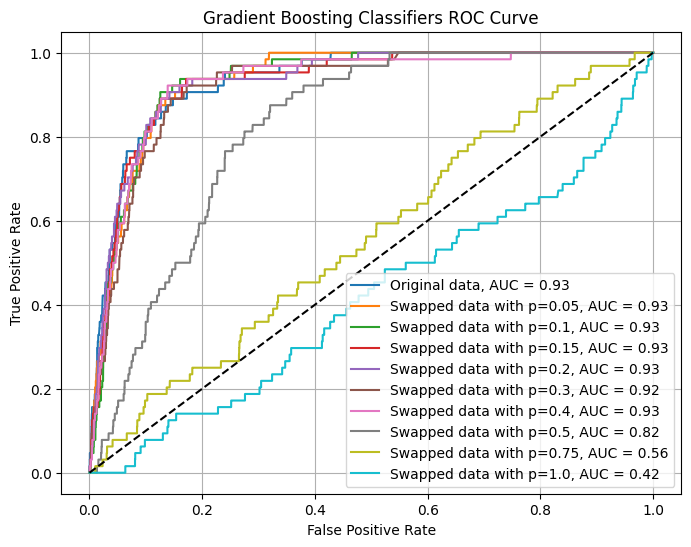

In [29]:
# Gradient Boosting Classifiers ROC Curve
plot_roc_curve(gb_classifiers[0], gb_classifiers[1:], X_test, y_test, p_values, "Gradient Boosting Classifiers ROC Curve")

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

I focus on their performance with the original data. Since accuracy can be misleading for imbalanced datasets, I will compare the classifiers on AUC scores. Random Forest performs the best (0.94), followed by Gradient Boosting (0.93). Then, Logistic Regression performs considerably well (0.90), just ahead of MLP (0.89) and SVM (0.88).

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

RF is the best classifier, as it works well with both numerical and categorical features without much preprocessing. Gradient Boosting is similar. Then, Logistic Regression, MLP and SVM have similar performance. I would expect SVM to perform better in a high-dimensional space, while MLP could probably perform better with further hyperparameter tuning. However, the existence of many categorical features is an issue for both. Logistic Regression, as a white-box model, performs quite well.

I think rank swapping is a good privacy-preserving addition to this task. All classifiers maintain (almost) their performance after rank swapping with p<=0.2. This allows a decent level of perturbing values for enhanced privacy. However, it is not easy to swap features with few unique values (e.g. categorical) and when this happens (p>=0.4), we see significant performance deterioration. However, for tasks with many numerical identifying features, I believe rank swapping is a effective option. 